# Linear Regression - White Wine Quality #

This is a data set on various qualities of some white wines, along with the associated quality rated on a scale of 1 to 10. I found this dataset on Kaggle, and from what I hear, it's a pretty popular dataset. In this regression, I tried to use the given qualities to predict the quality of the wine. I do have a slight suspicion, however, that quality might be too subjective to be able to linearly regress accurately

The dataset can be found here: https://www.kaggle.com/datasets/piyushagni5/white-wine-quality

## Data Analysis

In [3]:
import pandas as pd
import os
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

In [4]:
data_root = "data/"
filename = "winequality-white.csv"
filepath = os.path.join(data_root, filename)
df = pd.read_csv(filepath);
target = "quality";
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [5]:
# Seeing if any values are NaN
print(df.isna().sum())
# No NaNs!

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [6]:
print(df.dtypes)

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object


array([[<Axes: title={'center': 'quality'}>]], dtype=object)

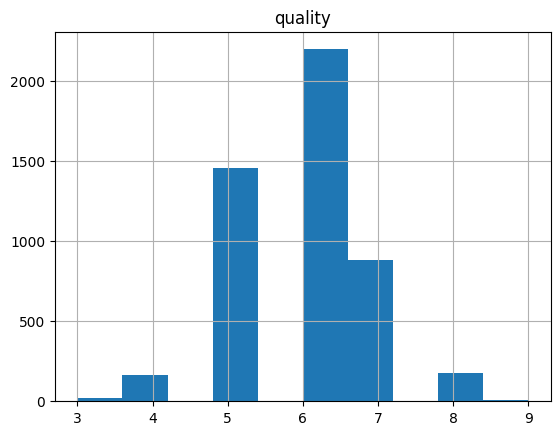

In [7]:
df.hist(target)

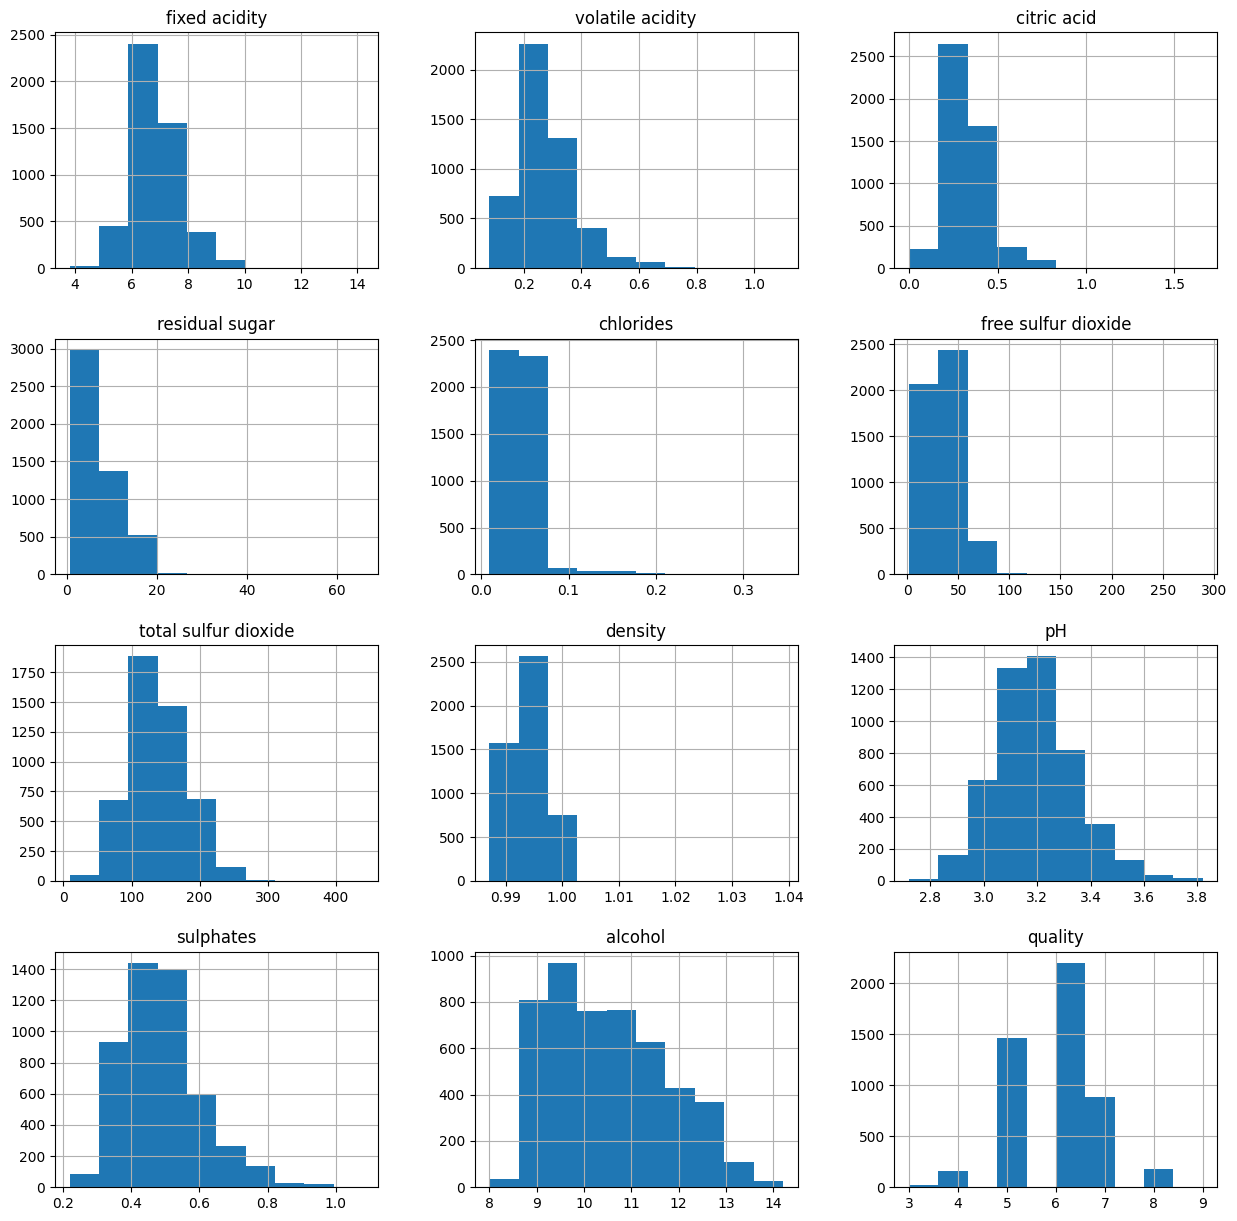

In [6]:
df.hist(figsize=(15,15));

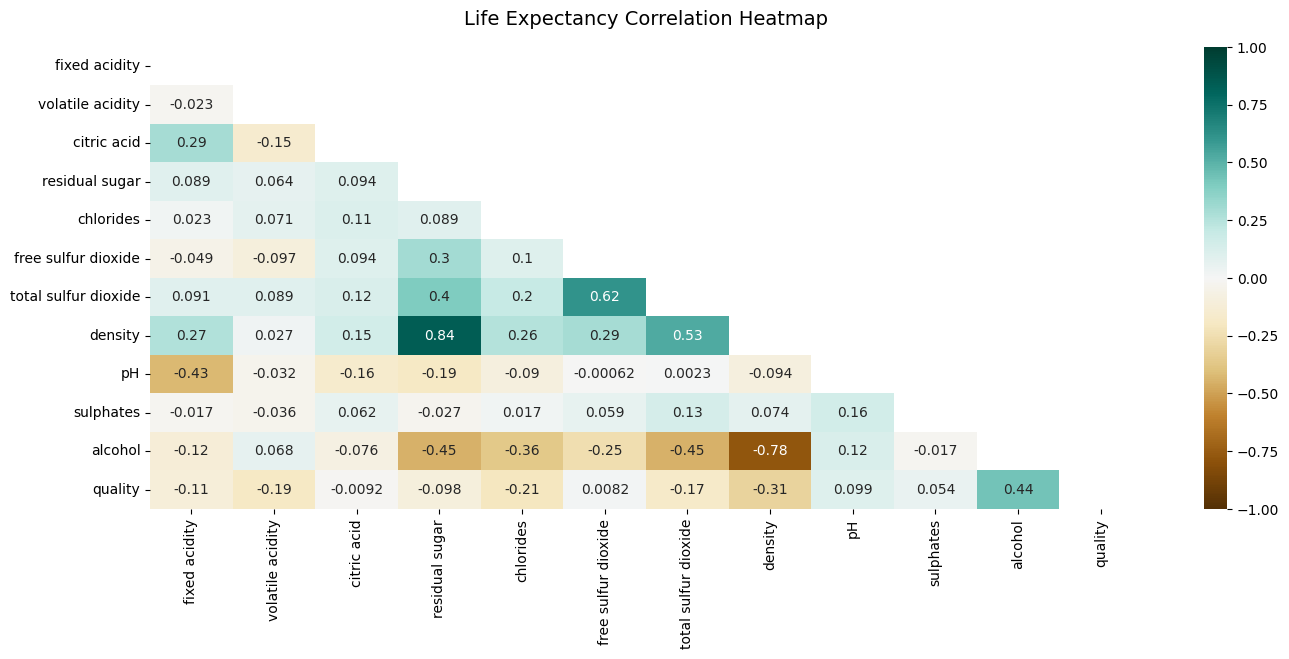

In [8]:
# Correlation Heat Map
corr = df.corr()
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(corr, dtype=np.bool))
heatmap = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Life Expectancy Correlation Heatmap', fontdict={'fontsize':14}, pad=16);
plt.show()

Unfortunately, nothing looks to correnate with Quality that well. The closest thing is density and alcohol, with -0.31 and 0.44, respectively.
There seems to be strong colinearity in other places, however, such as Density and Residual sugar, Density and Alcohol, and Total Sulfur Dioxide with Free Sulfur Dioxide.

Density and Alcohol being correlated is concerning, as they are the only two things that signifnicantly effect the quality of the wine. I will drop residual sugar and Free Sulfur Dioxide

In [9]:
# Dropping colinear terms
df = df.drop({"residual sugar", "free sulfur dioxide"}, axis = 1)

In [10]:
df.describe()

,fixed acidity,volatile acidity,citric acid,chlorides,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,0.045772,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,0.021848,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.009000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,0.036000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,0.043000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,0.050000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,0.346000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


## Linear Regression

In [11]:
def get_test_train(df, test_size = 0.2, random_state = False):
    target = "quality"    
    X = df.drop(target, axis=1)
    y = df[target]
    if random_state:
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size, random_state=42)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size)
    return X_train, X_test, y_train, y_test

In [12]:
def pre_process_data(df1):
    target = "quality"    

    # Use sklearn Imputers to fill in the categorical and numerical columns
    simple_median = SimpleImputer(strategy='median')
    simple_most_freq = SimpleImputer(strategy='most_frequent')
    
    num_cols = df1.select_dtypes(include=np.number).columns # numerical data

    df[num_cols] = simple_median.fit_transform(df[num_cols])

In [16]:
df2 = pd.read_csv(filepath);
#pre_process_data(df2);
#df2 = df2.drop({"residual sugar", "free sulfur dioxide"}, axis = 1)
#df2 = df2.drop("density", axis = 1)
X_train, X_test, y_train, y_test = get_test_train(df2, random_state = False)

In [17]:
lreg = LinearRegression()
model = lreg.fit(X_train, y_train)
pred = lreg.predict(X_test)
print(f"Train R-squared  = {model.score(X_train, y_train):.3}")
print(f"Test  R-squared  = {model.score(X_test, y_test):.3}")

Train R-squared  = 0.284
Test  R-squared  = 0.268


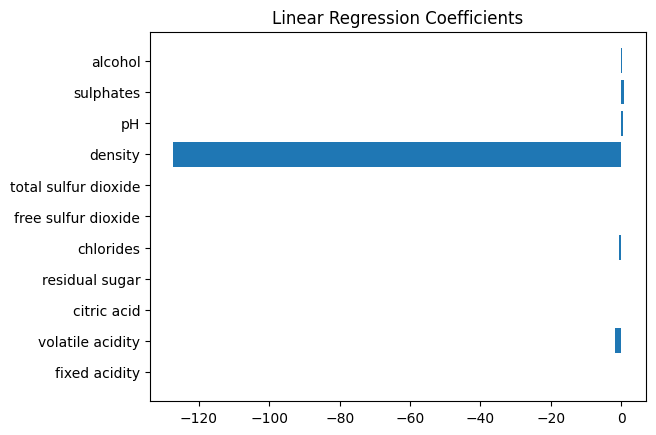

In [18]:
plt.barh(y = df2.drop(target,axis=1).columns, width=model.coef_);
plt.title("Linear Regression Coefficients");

This data definitely needs to be normalized, as Density's units are so small that it overpowers literally everything

From this, I have learned that you can make hydrochloric-acid flavored wine --> It would get a high rating if it was French

### Lasso Regrssion

In [19]:
lasso = Lasso(alpha=0.006, fit_intercept=True)
X_train, X_test, y_train, y_test = get_test_train(df2, random_state = False)
model = lasso.fit(X_train, y_train)
print(f"Train R-squared  = {model.score(X_train, y_train):.3}")
print(f"Test  R-squared  = {model.score(X_test, y_test):.3}")

Train R-squared  = 0.263
Test  R-squared  = 0.261


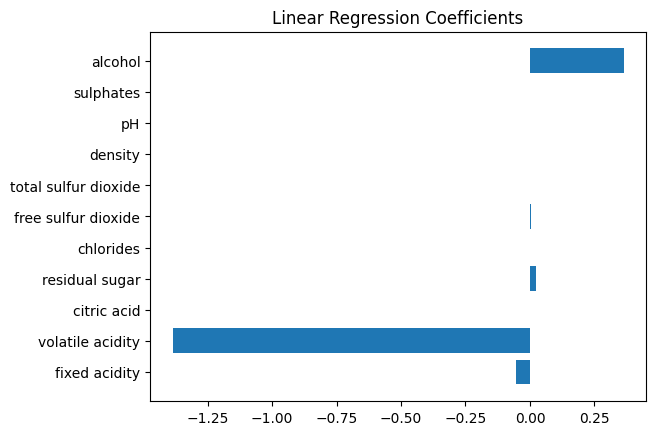

In [20]:
plt.barh(y = df2.drop(target,axis=1).columns, width=model.coef_);
plt.title("Linear Regression Coefficients");

### Ridge Regression

In [21]:
X_train, X_test, y_train, y_test = get_test_train(df2, random_state = False)
ridge = Ridge(alpha=10, fit_intercept=False)
model = ridge.fit(X_train, y_train)
print(f"Train R-squared  = {model.score(X_train, y_train):.3}")
print(f"Test  R-squared  = {model.score(X_test, y_test):.3}")

Train R-squared  = 0.272
Test  R-squared  = 0.248


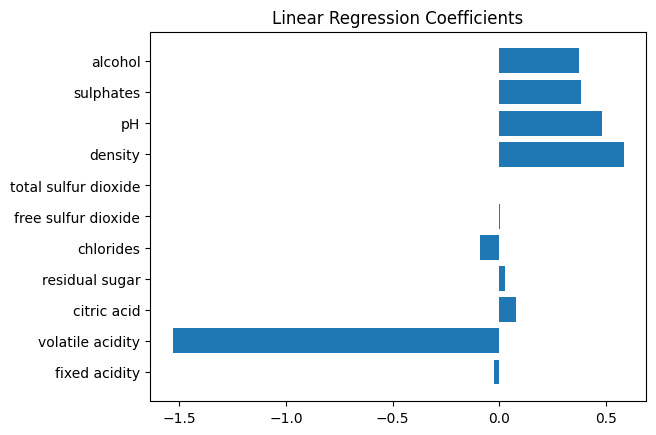

In [23]:
plt.barh(y = df2.drop(target,axis=1).columns, width=model.coef_);
plt.title("Linear Regression Coefficients");

I decided to continue by finding the best value of alpha for the ridge regression.

In [66]:
X_train, X_test, y_train, y_test = get_test_train(df2, random_state = False)

alphas = np.logspace(-2, 1, 1000, base=10)
r_train_scores = []
r_test_scores = []
for alpha in alphas:    
    ridge = Ridge(alpha=alpha, fit_intercept=False)
    model = ridge.fit(X_train, y_train)
    r_train_scores.append(model.score(X_train, y_train))
    r_test_scores.append(model.score(X_test, y_test))    

In [68]:
alphas2 = np.logspace(-2, 0, 1000, base=10)
l_train_scores = []
l_test_scores = []
for alpha in alphas2:    
    lasso = Lasso(alpha=alpha, fit_intercept=False)
    model = lasso.fit(X_train, y_train)
    l_train_scores.append(model.score(X_train, y_train))
    l_test_scores.append(model.score(X_test, y_test))

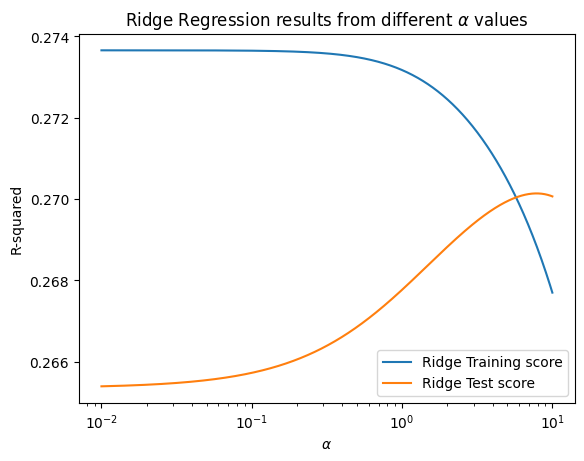

In [71]:
plt.title("Ridge Regression results from different $\\alpha$ values")
plt.xlabel("$\\alpha$")
plt.ylabel("R-squared")
plt.plot(alphas, r_train_scores, label="Ridge Training score")
plt.plot(alphas, r_test_scores, label="Ridge Test score")
plt.xscale("log")
plt.legend();

0.8952657125996396


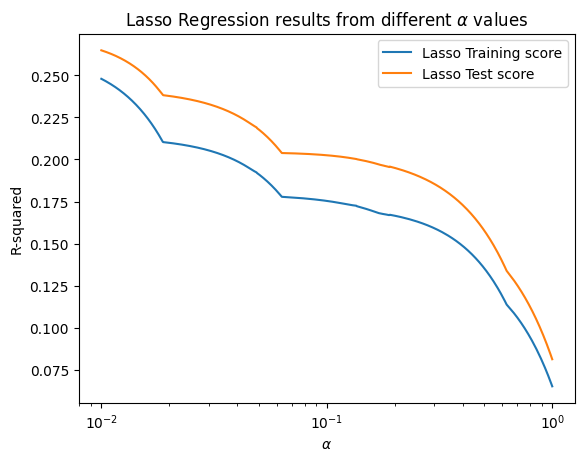

In [79]:
plt.title("Lasso Regression results from different $\\alpha$ values")
plt.xlabel("$\\alpha$")
plt.ylabel("R-squared")
plt.plot(alphas2, l_train_scores, label="Lasso Training score")
plt.plot(alphas2, l_test_scores, label="Lasso Test score")
plt.xscale("log")
plt.legend();

Seems like no matter what alpha's being used, the result only gets worse, peaking at about $R^{2}=0.27$. Potentially removing total sulfur dioxide instead of free might improve the score.

In [85]:
df3 = pd.read_csv(filepath)
df3 = df3.drop(['total sulfur dioxide'], axis=1)
X_train, X_test, y_train, y_test = get_test_train(df3, random_state = False)

In [86]:
ridge = Ridge(alpha=9, fit_intercept=False)
model = ridge.fit(X_train, y_train)
print(f"Train R-squared  = {model.score(X_train, y_train):.3}")
print(f"Test  R-squared  = {model.score(X_test, y_test):.3}")

Train R-squared  = 0.287
Test  R-squared  = 0.178


Dropping just total sulfur dioxide and not residual sugar and free sulfur dioxide improved $R^2$ by 0.2 for the training data, but sacrificed the test score by 0.1.